## Extending the number of datasources from tidal stations or satellite data

This notebooks explores different sources for extending the number of data sources for the sea level monitor. These extra sources can be used for getting a grip on regional differences in the speed with which the sea level rises.

The primary source of the tidal data is the PSMSL website. This website receives the tide gauge data from Rijkswaterstaat. The notebook get-data can be used to obtain the data.

In [1]:
import io
from nbformat import current
import bokeh.palettes
import bokeh.plotting
from bokeh.models import HoverTool

import matplotlib.pyplot as plt
import pyproj
from shapely.geometry import LineString, Point

import IPython.display

%matplotlib inline
bokeh.io.output_notebook()

C:\Anaconda3\lib\site-packages\nbformat\current.py:19: UserWarning: nbformat.current is deprecated.

- use nbformat for read/write/validate public API
- use nbformat.vX directly to composing notebooks of a particular version

  """)


Loading BokehJS ...

Define a function to read from functions from other notebooks

In [2]:
def execute_notebook(nbfile):
    
    with io.open(nbfile,encoding="utf8") as f:
        nb = current.read(f, 'json')
    
    ip = get_ipython()
    
    for cell in nb.worksheets[0].cells:
        if cell.cell_type != 'code':
            continue
        ip.run_cell(cell.input)


A set of functions to get data is defined in the notebook 'get-data.py' We import this here.

In [3]:
execute_notebook('get-data.ipynb')

C:\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Extended station collection

Currently the methods of the sea level monitor are applief on data of six tidal stations along the Dutch coast. For these stations the data is available via PSMSL, and the data are converted to RLR with NAP correction. There is however more data available from PSMSL, partly in RLR, and partly metric data (NAP). In the next section of this notebook, this data is retireved and compared to the 'official' data in the sea level monitor.

In [4]:
rlr_data = get_station_data(dataset_name='rlr_monthly', coastline_code=150)
met_data = get_station_data(dataset_name='met_monthly', coastline_code=150)

found point 52.3799 3.75
rlr_monthly 24 rlr
rlr_monthly 236 rlr
rlr_monthly 25 rlr
rlr_monthly 23 rlr
rlr_monthly 32 rlr
rlr_monthly 22 rlr
rlr_monthly 9 rlr
rlr_monthly 1551 rlr
rlr_monthly 20 rlr
found point 52.3799 3.75
met_monthly 24 met
met_monthly 236 met
met_monthly 25 met
met_monthly 23 met
met_monthly 32 met
met_monthly 22 met
met_monthly 9 met
met_monthly 19 met
met_monthly 1331 met
met_monthly 1837 met
met_monthly 36 met
met_monthly 1507 met
met_monthly 1551 met
met_monthly 35 met
met_monthly 20 met


Time series analysis of the gauge data, where the sea level y is described by a linear regression model with a trend, 18.6-year nodal cycle and the wind.

In [5]:
# Comments

colors = bokeh.palettes.Category20_15

stationsets = [
    ['VLISSINGEN', 'HOEK VAN HOLLAND', 'DEN HELDER', 'DELFZIJL', 'HARLINGEN', 'IJMUIDEN'],
    ['VLISSINGEN', 'HOEK VAN HOLLAND', 'DEN HELDER', 'DELFZIJL', 'HARLINGEN', 'IJMUIDEN', 'MAASSLUIS', 'ROOMPOT BUITEN', 'WEST-TERSCHELLING'],
    met_data['name'].squeeze().tolist()
]

for stationset in stationsets:
    fig = bokeh.plotting.figure(x_range=(1840, 2020), plot_width=950, plot_height=450)
    
    for color, name in zip(colors, stationset):
        # Check if station is available in rlr set, otherwise use metric set
        if name in rlr_data['name'].values:
            station = rlr_data.set_index('name').loc[name]
            linestyle = 'solid'
        else:
            station = met_data.set_index('name').loc[name]
            linestyle = 'dashed'
        
        # Some series contain -9999, we set these values to nan
        station['data'].loc[(station['data']['height'] < -9000), 'height'] = np.nan
        
        # Select the data after 1890
        df = station['data'].loc[station['data'].year >= 1890]
        #ax.plot(df['year'].values, df['height'].values/1e3, color=color, ls='', marker='.', label='', alpha=0.1)
    
        fit, names = linear_model(df, with_wind=False, with_season=False)
        
        fig.line(
            fit.model.exog[:, 1] + 1970,
            fit.predict()/1e3,
            line_width=3,
            alpha=0.8,
            legend=station.name,
            color=color,
            line_dash=linestyle)

    fig.legend.location = "top_left"
    fig.yaxis.axis_label = 'Sea water level (m+NAP)'
    fig.xaxis.axis_label = 'Year'
    
    bokeh.io.show(fig)


[DESCRIBE RESULTS]
Some records are significantly shorter (due to Deltawerken)
Note that the data of some stations are the metric data (without NAP correction). Mention which ones.
[SOURCE in Frederikse et al. (2016)] says at leat a 60 year record is needed to detect a 2 mm/year trend

## Differences along the Dutch coast

In the next step, the linear model will be used to determine regional differences along the Dutch coast. To do so, every station along the dutch coast is projects on a line along the coast. The coefficient of the linear trend component, as well as the standard error in this coefficient are used to show the speed of the sea level rise along the coast.

In [6]:
crds = [
    (12000, 377000),
    (12000, 378000),
    (20407, 397159),
    (87784, 468350),
    (111514, 554797),
    (189909, 600139),
    (263643, 607342),
    (264643, 607342)
]
    
WGS84 = pyproj.Proj(init='epsg:4326')
RD = pyproj.Proj(init='epsg:28992')

kustlijn = LineString(crds)

# Create dataframe with trend
columns = pandas.MultiIndex.from_product((['rlr', 'met', 'satellite'], ['coeff', 'stderr']))
trend_values = pandas.DataFrame(columns=columns, index=met_data['name'].values.tolist())

for station_data, tag in zip([rlr_data, met_data], ['rlr', 'met']):
    for name, station in station_data.iterrows():
        # Select the data from 1890 till now
        df = station['data'].loc[station['data'].year >= 1890]
        # Fit the linear model with wind
        fit, names = linear_model(df, with_wind=False, with_season=False)
        # Get the summary
        smry = fit.summary2(xname=names)
        # Determine the coefficient and standard error from the tables, and add to dataframe
        trend_values.loc[station['name'], (tag, 'coeff')] = float(smry.tables[1].values[1, 0])
        trend_values.loc[station['name'], (tag, 'stderr')] = float(smry.tables[1].values[1, 1])
        station_data.loc[name, 'trend_coef'] = float(smry.tables[1].values[1, 0])
        station_data.loc[name, 'trend_stderr'] = float(smry.tables[1].values[1, 1])

        # Project the station on the coast line, to determine the projected distance
        station_data.loc[name, 'proj_distance'] = kustlijn.project(Point(pyproj.transform(WGS84, RD, station['lon'], station['lat'])))

    # Sort the station data by projected distance for plotting
    station_data.sort_values(by='proj_distance', inplace=True)



In [34]:
names = ['RLR6', 'RLR9', 'Metric']

hover = HoverTool(tooltips=[
    ("station", "@name"),
    ("dataset", "@dataset"),
    ("(lon,lat)", "(@lon, @lat)"),
    ("coef", "@trend_coef"),
    ("stderr", "@trend_stderr"),
])
    
fig = bokeh.plotting.figure(plot_width=900, plot_height=400)
fig.add_tools(hover)
colors = ['blue', 'green', 'orange']
source = {}

# Loop trough the different datasets to be plotted
for name, stationset, color in zip(names, stationsets, colors):
    # Determine dataset
    station_data = rlr_data if 'rlr' in name.lower() else met_data
    
    # Select stations from station set
    station_data = station_data.set_index('name').loc[stationset]
    station_data.sort_values(by='proj_distance', inplace=True)
    
    dist = station_data['proj_distance'].values
    
    source[name] = station_data[['lat', 'lon', 'trend_coef', 'trend_stderr', 'proj_distance']]
    source[name]['proj_distance'] /= 1000
    source[name]['dataset'] = name
    
    # Add

    # Draw the sea level trend
    fig.line(dist/1000, station_data['trend_coef'].values, line_width=2, legend=name, color=color, alpha=0.5)
    fig.circle('proj_distance', 'trend_coef', size=7, color=color, alpha=0.5, source=source[name])
    
    # Fill between std err
    lower = station_data['trend_coef'].values - station_data['trend_stderr'].values
    upper = station_data['trend_coef'].values + station_data['trend_stderr'].values
    fig.patch(np.r_[dist, dist[::-1]]/1000, np.r_[lower, upper[::-1]], color=color, fill_alpha=0.2, line_alpha=0.0)


fig.legend.location = "top_left"
fig.yaxis.axis_label = 'Average sea water level (m+NAP)'
fig.xaxis.axis_label = 'Distance along coast'
bokeh.io.show(fig)


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [8]:
names = ['RLR6', 'RLR9', 'Metric']
fig = bokeh.plotting.figure(x_range=(1885, 2020), plot_width=900, plot_height=400)
colors = ['blue', 'green', 'orange']

# Loop trough the different datasets to be plotted
for name, stationset, color in zip(names, stationsets, colors):
    # Determine dataset
    data = rlr_data if 'rlr' in name.lower() else met_data
    
    # Select stations from station set
    data = data.set_index('name').loc[stationset]
    
    # compute the mean for metric data
    grouped = pandas.concat(data['data'].tolist())[['year', 't', 'height', 'u', 'v', 'u2', 'v2']].groupby(['year', 't'])
    mean = grouped.mean().reset_index()
    # filter out non-trusted part (before NAP)
    mean = mean[mean['year'] >= 1890].copy()
    linear_fit, names = linear_model(mean, with_wind=False, with_season=False)

    # Draw the sea level trend
    fig.line(
        linear_fit.model.exog[:, 1] + 1970, 
        linear_fit.predict()/1000.,
        line_width=3, 
        legend=name, 
        color=color,
        alpha=0.5
    )

fig.legend.location = "top_left"
fig.yaxis.axis_label = 'Average sea water level (m+NAP)'
fig.xaxis.axis_label = 'year'
bokeh.io.show(fig)

First we compare the effects of adding the three extra stations for which the RLR data can be retrieved at PSMSL. The trends show a that adding the three stations gives higher values around 1900 and equal values around 2000. These differences can be explained by viewing the trends of the 3 extra stations. The addition of West-Terschelling and Roompot-Buiten gives lower values in the more recent part of the trend, while adding Maassluis raises the trend over the full range.

We also compare the rlr data to the metric stations. The trend does not differ considerably from the RLR trends. However, as we saw before, many of the metric stations have a shorter time range for which the data are available. Also some of the 'metric stations' are located at a location not directly at the coast, but for example inside the Eastern Scheldt. The quality if these data is thus worse than the data of the rlr stations. 

The trends shown in the following table show that the uncertainty around the metric data is larger, while there is no clear added value in using the extra dataset.

In [9]:
trend_values.dropna(how='all', axis=1)

rlr                 met           
                       coeff     stderr    coeff     stderr
DELFZIJL             1.96483  0.0906629  1.93285  0.0906437
WEST-TERSCHELLING     1.1558   0.134337  1.01774   0.133946
HARLINGEN            1.33325  0.0930253  1.30527  0.0929743
DEN HELDER           1.51113  0.0802395  1.44318  0.0802333
IJMUIDEN              2.1365   0.076006  2.05256  0.0761078
HOEK VAN HOLLAND     2.37837  0.0678681  2.26645   0.067959
MAASSLUIS            1.74248  0.0700071  1.64655  0.0700645
HELLEVOETSLUIS           NaN        NaN  1.79136   0.139246
STELLENDAM BUITEN        NaN        NaN  3.91898    1.00524
HARINGVLIET              NaN        NaN  2.51307   0.762284
BROUWERSHAVEN            NaN        NaN   1.9461   0.128966
BROUWERSHAVENSE GAT      NaN        NaN  1.65435   0.470682
ROOMPOT BUITEN       2.73719   0.536844  1.26855   0.462415
ZIERIKZEE                NaN        NaN   1.9804  0.0987289
VLISSINGEN           2.17441  0.0607146   2.0545  0.0607678

## Satellite data

Next to the data from the tidal stations, there is also sea level data available from satellite observations. In this section of the notebook, we explore these data and compare them to the data from the tidal stations.

Now we load the satellite data from the netCDF4 file. First de latitude en longitude (axes) of the data are loaded, after which we use the data around the Dutch coast.

In [10]:
# Import sea level data
ds = netCDF4.Dataset(r'd:\\Documents\\2695.40 Zeespiegelstijging 2017\\Toeleveringen\\dt_global_merged_msla_h_merged.nc')

# Get longitude and latitude
lon = ds.variables['lon'][:]
lat = ds.variables['lat'][:]

# Determine relevant part
lon_selection = lon[(lon > 2) * (lon < 7)]
lat_selection = lat[(lat > 51) * (lat < 54.5)]

# Download sea level averages for relevant part
sla = ds.variables['sla'][:, np.in1d(lat, lat_selection), np.in1d(lon, lon_selection)]

# Get the time stamps of the 
time = netCDF4.num2date(ds.variables['time'][:], ds.variables['time'].units)

We apply the linear model of the sea level data on the data:

In [11]:
# Load coorindate systems for transformation
WGS84 = pyproj.Proj(init='epsg:4326')
RD = pyproj.Proj(init='epsg:28992')

# Empty list for appending satellite data per coordinate
satellite_data = []

# Loop trough points in relevant range
years = [time[i].year + time[i].month/12. for i in range(len(time))]
coeff = np.zeros((len(lat_selection), len(lon_selection)))
error = np.zeros_like(coeff)

for i, x in enumerate(lon_selection):
    for j, y in enumerate(lat_selection):
        # Add data
        data = pandas.DataFrame(columns=['year', 'height'])
        data['year'] = years
        data['height'] = sla[:, j, i]
        
        # Skip the coordinate if it is masked
        if any(sla[:, j, i].mask):
            coeff[j, i] = np.nan
            error[j, i] = np.nan
            continue            
        
        # Fit model
        fit, names = linear_model(data, with_wind=False, with_season=False)
        smry = fit.summary2(xname=names)
        
        # Add to list
        trend_coef = float(smry.tables[1].values[1, 0])
        trend_stderr = float(smry.tables[1].values[1, 1])
        satellite_data.append([x, y, trend_coef, trend_stderr, data])
        
        # Add to 2d-arrays
        coeff[j, i] = trend_coef
        error[j, i] = trend_stderr
        
satellite_data = pandas.DataFrame(satellite_data, columns=['lon', 'lat', 'trend_coef', 'trend_stderr', 'data'])

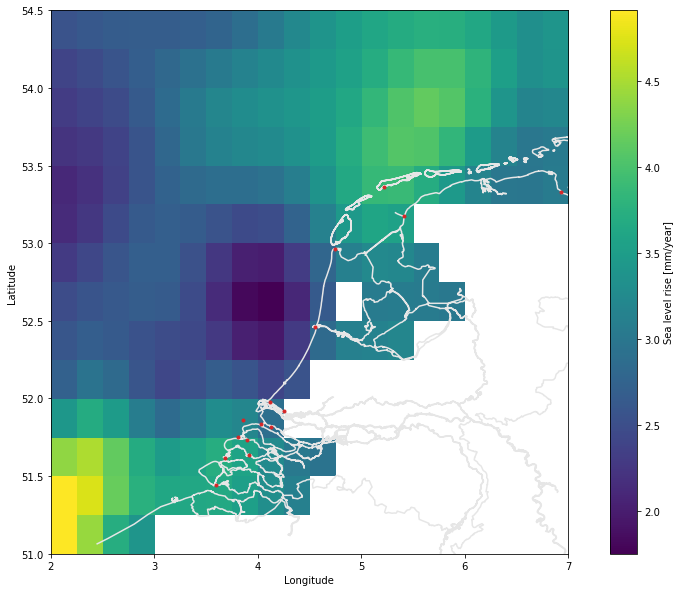

In [94]:
xy = np.loadtxt(r'landboundary.txt')
fig, ax = plt.subplots(figsize=(15, 10))

xy = pyproj.transform(RD, WGS84, *xy.T)

ax.plot(*xy, color='0.9')
ax.plot(*met_data[['lon', 'lat']].values.T, marker='.', color='C3', ls='')

lon_step = lon_selection[1] - lon_selection[0]
lat_step = lat_selection[1] - lat_selection[0]

ws = (min(lon_selection) - 0.5 * lon_step, min(lat_selection) - 0.5 * lat_step)
en = (max(lon_selection) + 0.5 * lon_step, max(lat_selection) + 0.5 * lat_step)
im = ax.imshow(coeff*1000, extent=(ws[0], en[0], ws[1], en[1]), origin='lower', aspect=1.5)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

cb = plt.colorbar(im)
cb.set_label('Sea level rise [mm/year]')




We compare this data to the tidal gauge data. To do so, we interpolate the coastline on which we projected the gauges earlier on in the satellite data. Note that for this interpolation the NaN values are filled with the mean of the values in the researched area. This can affect the result for locations close to the white parts in the figure above.

In [36]:
from scipy.interpolate import interp2d

# Fill copies of the 2d-arrays with average values at the position of the NaN's
coeff_notnull = coeff.copy()
coeff_notnull[np.isnan(coeff_notnull)] = np.nanmean(coeff)
error_notnull = error.copy()
error_notnull[np.isnan(error_notnull)] = np.nanmean(error)

# Define interpolation function
f_coeff = interp2d(lon_selection, lat_selection, coeff_notnull, kind='linear')
f_error = interp2d(lon_selection, lat_selection, error_notnull, kind='linear')

# Define a grid for plotting
dist = np.linspace(0, kustlijn.length, 200)

# Interpolate coordinaties along the coastline
xy = np.vstack([pyproj.transform(RD, WGS84, *kustlijn.interpolate(i).coords[0]) for i in dist])
z_coeff = np.array([f_coeff(x, y)[0] for x, y in xy]) * 1000
z_error = np.array([f_error(x, y)[0] for x, y in xy]) * 1000

# Draw the sea level trend
fig = bokeh.plotting.figure(x_range=(0, max(dist)/1000), y_range=(0, 5.0), plot_width=900, plot_height=400)

fig.line(dist/1000, z_coeff, line_width=3, legend='coefficient of linear trend', color='blue', alpha=0.5)
fig.patch(np.r_[dist, dist[::-1]]/1000, np.r_[z_coeff-z_error, (z_coeff+z_error)[::-1]], color='blue', fill_alpha=0.2, line_alpha=0.2, legend='std error interval of linear trend')

fig.legend.location = "bottom_left"
fig.xaxis.axis_label = 'Distance along coast [km]'
fig.yaxis.axis_label = 'Sea level rise per year [mm] (trend)'
bokeh.io.show(fig)

The first thing to be noted on this data is that the spread in this data is much larger. This is to be expected since the data is available since 1993, which is much shorter than the tidal data. The second thing to be noted is that the trend coefficient from the data is larger for the combination of satellite data and period, compared to the tidal data we showed before.

To get a better view of the usability of satellite data for estimating the (regional) sea level rise speed along the Dutch coast, we compare equal periods for the sattelite data and the tidal data. We interpolate the locations of the tidal stations in the satellite data, to get the trend at the same location.

In [89]:
# Create dataframe with trend
columns = pandas.MultiIndex.from_product((['rlr', 'satellite'], ['coeff', 'stderr']))
trend_values = pandas.DataFrame(columns=columns, index=rlr_data['name'].values.tolist())

# Determine the trends again for the rlr data
for name, station in rlr_data.iterrows():
    # Select the data from 1890 till now
    df = station['data'].loc[station['data'].year >= 1993]
    
    # Fit the linear model with wind
    fit, names = linear_model(df, with_wind=False, with_season=False)
    # Get the summary
    smry = fit.summary2(xname=names)
    # Determine the coefficient and standard error from the tables, and add to dataframe
    trend_coef = float(smry.tables[1].values[1, 0])
    trend_err = float(smry.tables[1].values[1, 1])
    station_data.loc[name, 'trend_coef'] = trend_coef
    station_data.loc[name, 'trend_stderr'] = trend_err
    trend_values.loc[station['name'], ('rlr', 'coeff')] = trend_coef
    trend_values.loc[station['name'], ('rlr', 'stderr')] = trend_err
    # Project the station on the coast line, to determine the projected distance
    station_data.loc[name, 'proj_distance'] = kustlijn.project(Point(pyproj.transform(WGS84, RD, station['lon'], station['lat'])))

# Sort the station data by projected distance for plotting
station_data.sort_values(by='proj_distance', inplace=True)

# Determine the trends for the satellite data at the locations of the rlr stations
# Interpolate the for all (nine) RLR stations
for _, station in rlr_data.iterrows():
    trend_values.loc[station['name'], ('satellite', 'coeff')] = f_coeff(*station[['lon', 'lat']].values)[0] * 1000
    trend_values.loc[station['name'], ('satellite', 'stderr')] = f_error(*station[['lon', 'lat']].values)[0] * 1000


In [90]:
trend_values

rlr           satellite          
                     coeff    stderr     coeff    stderr
VLISSINGEN         3.41202  0.729268   3.66833  0.875533
ROOMPOT BUITEN     3.37883  0.746104   3.68774  0.918776
HOEK VAN HOLLAND   2.96762  0.799398    2.7089  0.942983
MAASSLUIS          2.35407  0.815856   2.90831  0.906199
IJMUIDEN           2.66601   0.91342   2.61885  0.924794
DEN HELDER         2.25974  0.994643   3.07708  0.931964
WEST-TERSCHELLING  4.03203   1.06961   3.86213  0.936762
HARLINGEN           4.2269   1.18862   3.56716  0.887904
DELFZIJL           3.51976   1.14513   3.06756  0.902371

In [93]:
names = ['RLR9', 'Satellite']
pandas.options.mode.chained_assignment = None

hover = HoverTool(tooltips=[
    ("station", "@name"),
    ("dataset", "@dataset"),
    ("(lon,lat)", "(@lon, @lat)"),
    ("coef", "@trend_coef"),
    ("stderr", "@trend_stderr"),
])
    
fig = bokeh.plotting.figure(y_range=(0, 5.5), plot_width=900, plot_height=400)
fig.add_tools(hover)
colors = ['blue', 'orange']
source = {}

# Loop trough the different datasets to be plotted
dist = rlr_data['proj_distance'].values

source['RLR9'] = rlr_data[['lat', 'lon', 'trend_coef', 'trend_stderr', 'proj_distance', 'name']]
source['RLR9']['proj_distance'] /= 1000
source['RLR9']['dataset'] = 'RLR9'

source['Satellite'] = rlr_data[['lat', 'lon', 'proj_distance', 'name']]
source['Satellite']['proj_distance'] /= 1000
source['Satellite']['dataset'] = 'Satellite'
source['Satellite']['trend_coef'] = np.nan
source['Satellite']['trend_stderr'] = np.nan
source['Satellite'][['trend_coef', 'trend_stderr']] = trend_values.loc[source['Satellite']['name'], 'satellite'].values
    
for name, color in zip(names, colors):
    
    data = source[name]
    
    # Draw the sea level trend
    fig.line(dist/1000, data['trend_coef'].values, line_width=2, legend=name, color=color, alpha=0.5)
    fig.circle('proj_distance', 'trend_coef', size=7, color=color, alpha=0.5, source=source[name])
    
    # Fill between std err
    lower = data['trend_coef'].values - data['trend_stderr'].values
    upper = data['trend_coef'].values + data['trend_stderr'].values
    fig.patch(np.r_[dist, dist[::-1]]/1000, np.r_[lower, upper[::-1]], color=color, fill_alpha=0.2, line_alpha=0.0)

fig.legend.location = "top_left"
fig.yaxis.axis_label = 'Linear trend coefficient (mm/year)'
fig.xaxis.axis_label = 'Distance along coast'
bokeh.io.show(fig)


The results from the satellite data match well with the results from the tidal stations. The 'zig-zag' differences are near mean filled NaN-values, so that could be a possible explaination for these differences. The standard errors have the some order of magnitude, however the standard error is somewhat larger in the Waddensea.

The satellite data are a nice addition to the tidal station data, also because they span a large area, instead of a few point sources. This can help in identifying causes of regional sea level changes. A downside is the relatively short time series for which they are available. This results in a large spread, so the uncertainty around the 'actual' trend is large. This makes extrapolating to the near future (a usefull application for practical purposes) tricky.



## Concluding
In this notebook possible sources for obtaining more data for the sea level monitor where explored. This extra data can subsequently be used to get a better view on regional differences in the speed with which the sea level rises.

First the extra tide gauges available from PSMSL where considered. Three extra stations, Maassluis, West-terschelling en Roompot Buiten, are available in the official rlr-dataset. The first two are located closely to other RLR-stations, while the last has only a short timeseries. Adding these stations to the sea level monitor thus provides not much added value.

A second source of extra data is the metric dataset available on PSMSL. The data from this dataset is however from worse quality (which is also clearly communicated by PSMSL) which makes the dataset also not very usable for practical purposes.

A last source of data is satellite data available though AVISO altimetry. These data coincide reasonably well with the tidal gauge data, and are available for the complete Northsea (and world), with an resolution of a quarter degree longitude and latitide. The data are however available from 1993 on, which gives a large uncertainty around the trend. This makes it difficult to use it for short term predictions. The availability across the whole North Sea makes it however a good source for finding or checking sources of sea level rise differences.